# Example code for fitting Normal and Log-Normal Distributions using L-Moments

Consider the same dataset from Problem 6.17 that we fit LN2 and LN3 distributions to using MOM and MLE. Here we'll show how to do the same using L-Moments. We'll use the [lmoments3](https://lmoments3.readthedocs.io/stable/) library for this, so we've installed that and added it to our imports below.

In [1]:
!pip install lmoments3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.optimize import brentq as root
from google.colab import drive
import lmoments3 as lm

# allow access to google drive
drive.mount('/content/drive')

maxQ = pd.read_csv("drive/MyDrive/Colab Notebooks/CE6280/Data/Problem6.17.csv")

Mounted at /content/drive


We can use the function `lmom_ratios` to print the L-moment ratios of our data up to `nmom` number of moments.

In [3]:
L1, L2, T3, T4 = lm.lmom_ratios(maxQ["Flow"], nmom=4)
print("L1: %0.2f" % L1)
print("L2: %0.2f" % L2)
print("T3: %0.2f" % T3)
print("T4: %0.2f" % T4)

L1: 1004.49
L2: 417.62
T3: 0.51
T4: 0.32


How do these compare with product moments?

In [4]:
print(np.mean(maxQ["Flow"]))
print(np.std(maxQ["Flow"], ddof=1))
print(ss.skew(maxQ["Flow"], bias=False))
print(ss.kurtosis(maxQ["Flow"], bias=False))

1004.4878048780488
930.8433037292373
2.369082611922457
5.252508901203168


The 1st moments are the same (this is always true), but the L-moment ratios are all less than the product moment ratios.  

Now let's fit a normal distribution to the data using the L-moments.

In [5]:
from lmoments3 import distr

norm_params = distr.nor.lmom_fit(maxQ["Flow"])
print(norm_params)

OrderedDict([('loc', 1004.4878048780488), ('scale', 740.2156356616999)])


Now that we know the parameters, we can estimate the 100-year flood and plot the distribution fit using the scipy.stats library we've used before.

100-year flood estimate: 2726 cms


Text(0, 0.5, 'Probability Density')

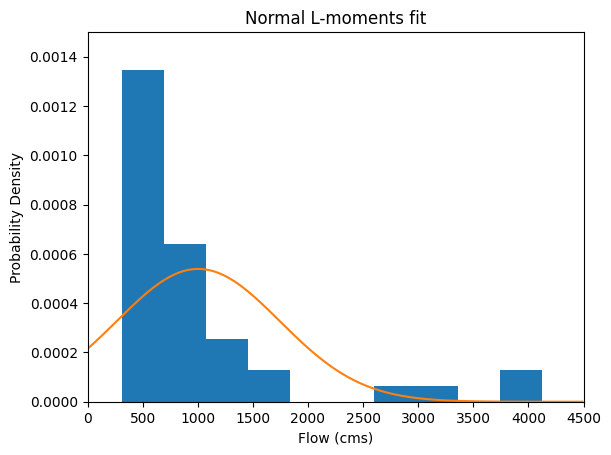

In [6]:
mu_fit = norm_params["loc"]
sigma_fit = norm_params["scale"]

q0_99_N_Lmom = ss.norm.ppf(0.99, mu_fit, sigma_fit)
print("100-year flood estimate: %0.0f cms" % q0_99_N_Lmom)

x = np.arange(0,4500,10)
f_x = ss.norm.pdf(x, mu_fit, sigma_fit)

plt.hist(maxQ["Flow"], density=True)
plt.plot(x,f_x)
plt.ylim([0,0.0015])
plt.xlim([0,4500])
plt.title('Normal L-moments fit')
plt.xlabel('Flow (cms)')
plt.ylabel('Probability Density')

Not surprisingly, the fit is still bad. So let's use the L-Moments to fit an LN2 and LN3 distribution.  

This is not among the probability distributions available in the lmoments3 library, so we'll have to write our own code to do this like we did for MOM. Lucky for you, this is the only distribution we'll use that is not already coded in `lmoments3` 😉.

The theoretical L-moments of the LN3 distribution are:  

\begin{align}
\lambda_1 &= \xi + \exp\Big(\mu + \frac{\sigma^2}{2}\Big)\\
\lambda_2 &= \exp\Big(\mu + \frac{\sigma^2}{2}\Big) \text{erf}\Big(\frac{\sigma}{2}\Big)\\
\tau_3 &= \frac{\frac{6}{\sqrt{\pi}} \int_0^{\sigma/2} \text{erf}(\frac{x}{\sqrt{3}}) \exp(-x^2)dx}{\text{erf}(\frac{\sigma}{2})} \\
\text{where}\\
\text{erf}(z) &= \frac{2}{\sqrt{\pi}} \int_0^{z} e^{-t^2}dt
\end{align}

For an LN2 distribution, we can set $\tau=0$ in the first equation and then solve the system of the first two equations for $\mu$ and $\sigma$.  

For an LN3 distribution, similar to MOM, we can solve for $\sigma$ using the third L-moment ratio, plug that into the second L-moment to solve for $\mu$ and then plug both into the first moment to solve for $\tau$.

LN2 Lmom mu: 6.61
LN2 Lmom sigma: 0.77
LN2 Lmom tau: 0.00
LN2 Lmom 100-yr flood: 4506 cms


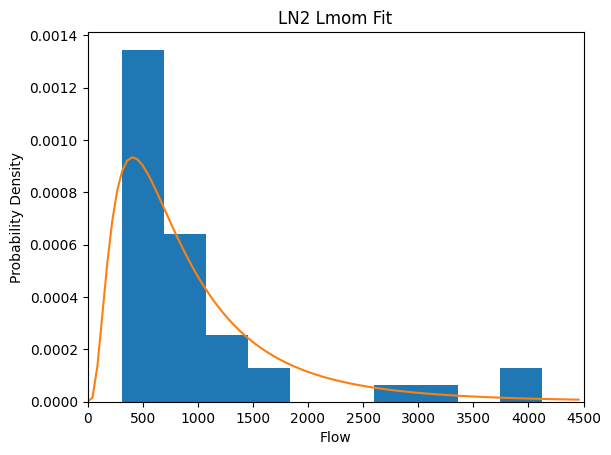



LN3 Lmom mu: 5.97
LN3 Lmom sigma: 1.12
LN3 Lmom tau: 273.69
LN3 Lmom 100-yr flood: 5555 cms


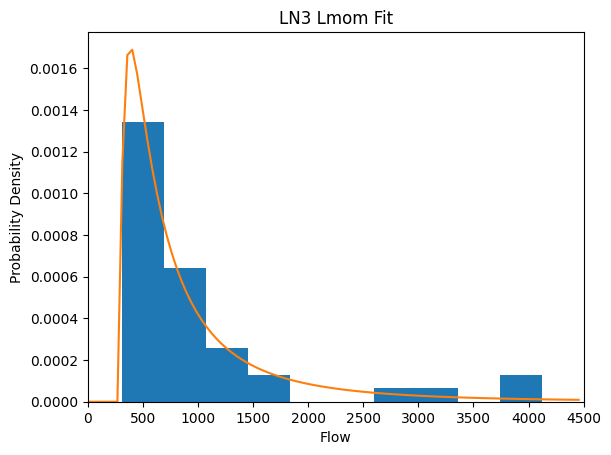

In [8]:
import math
import scipy.integrate as integrate
import scipy.special as special

def fitLN(data, npars):
  L1, L2, T3, T4 = lm.lmom_ratios(data, nmom=4)
  if npars == 2:
    tau = 0
    sigma = root(lambda x: special.erf(x/2) - L2/L1, 0.01, L2)
    mu = np.log(L1) - 0.5*sigma**2
  elif npars == 3:
    sigma = root(lambda x: T3 - (6/np.sqrt(math.pi)) * \
                 integrate.quad(lambda y: special.erf(y/np.sqrt(3))*np.exp(-y**2), 0, x/2)[0] \
                 / math.erf(x/2),
                 0.01, L2)
    mu = np.log(L2 / math.erf(sigma/2)) - 0.5*sigma**2
    tau = L1 - np.exp(mu + 0.5*sigma**2)

  return sigma, tau, mu

def findLNreturnPd(sigma, tau, mu, T):
  q_T = ss.lognorm.ppf(1-1/T, sigma, tau, np.exp(mu))

  return q_T

def plotHistPDF(data, sigma, tau, mu, min, max, title):
  x = np.arange(min, max,(max-min)/100)
  f_x = ss.lognorm.pdf(x, sigma, tau, np.exp(mu))

  plt.hist(data, density=True)
  plt.plot(x,f_x)
  plt.xlim([min, max])
  plt.title(title)
  plt.xlabel('Flow')
  plt.ylabel('Probability Density')
  plt.show()

sigma_LN2_Lmom, tau_LN2_Lmom, mu_LN2_Lmom = fitLN(maxQ["Flow"], 2)
q0_99_LN2_Lmom = findLNreturnPd(sigma_LN2_Lmom, tau_LN2_Lmom, mu_LN2_Lmom, 100)

sigma_LN3_Lmom, tau_LN3_Lmom, mu_LN3_Lmom = fitLN(maxQ["Flow"], 3)
q0_99_LN3_Lmom = findLNreturnPd(sigma_LN3_Lmom, tau_LN3_Lmom, mu_LN3_Lmom, 100)

print("LN2 Lmom mu: %0.2f" % mu_LN2_Lmom)
print("LN2 Lmom sigma: %0.2f" % sigma_LN2_Lmom)
print("LN2 Lmom tau: %0.2f" % tau_LN2_Lmom)
print("LN2 Lmom 100-yr flood: %0.0f cms" % q0_99_LN2_Lmom)
plotHistPDF(maxQ["Flow"], sigma_LN2_Lmom, tau_LN2_Lmom, mu_LN2_Lmom, 0, 4500, "LN2 Lmom Fit")
print("\n")
print("LN3 Lmom mu: %0.2f" % mu_LN3_Lmom)
print("LN3 Lmom sigma: %0.2f" % sigma_LN3_Lmom)
print("LN3 Lmom tau: %0.2f" % tau_LN3_Lmom)
print("LN3 Lmom 100-yr flood: %0.0f cms" % q0_99_LN3_Lmom)
plotHistPDF(maxQ["Flow"], sigma_LN3_Lmom, tau_LN3_Lmom, mu_LN3_Lmom, 0, 4500, "LN3 Lmom Fit")

Let's integrate this into our class for fitting LN2 and LN3 with MOM and MLE.

In [11]:
class Distribution:
  def __init__(self):
    self.xbar = None
    self.var = None
    self.skew = None
    self.kurtosis = None
    self.L1 = None
    self.L2 = None
    self.T3 = None
    self.T4 = None

  def findMoments(self, data):
    self.xbar = np.mean(data)
    self.var = np.var(data, ddof=1)
    self.skew = ss.skew(data, bias=False)
    self.kurtosis = ss.kurtosis(data, bias=False)

  def findLmoments(self, data):
    self.L1, self.L2, self.T3, self.T4 = lm.lmom_ratios(data, nmom=4)

class LogNormal(Distribution):
  def __init__(self):
    super().__init__()
    self.mu = None
    self.sigma = None
    self.tau = None

  def fit(self, data, method, npars):
    assert method == 'MLE' or method == 'MOM' or method == "Lmom","method must = 'MLE','MOM', or 'Lmom'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"

    self.findMoments(data)
    self.findLmoments(data)
    if method == 'MLE':
      if npars == 2:
        shape, loc, scale = ss.lognorm.fit(data, floc=0)
      elif npars == 3:
        shape, loc, scale = ss.lognorm.fit(data)

      self.mu = np.log(scale)
      self.sigma = shape
      self.tau = loc
    elif method == 'MOM':
      if npars == 2:
        self.sigma = np.sqrt(np.log(1+self.var/self.xbar**2))
        self.mu = np.log(self.xbar) - 0.5*self.sigma**2
        self.tau = 0
      elif npars == 3:
        self.sigma = root(lambda x: (np.exp(3*x**2)-3*np.exp(x**2)+2) / (np.exp(x**2)-1)**(3/2) - self.skew,
                   0.01, np.std(np.log(data),ddof=1))
        self.mu = 0.5 * (np.log(self.var / (np.exp(self.sigma**2)-1)) - self.sigma**2)
        self.tau = self.xbar - np.exp(self.mu + 0.5*self.sigma**2)
    elif method == 'Lmom':
      if npars == 2:
        self.tau = 0
        self.sigma = root(lambda x: special.erf(x/2) - self.L2/self.L1, 0.01, self.L2)
        self.mu = np.log(self.L1) - 0.5*self.sigma**2
      elif npars == 3:
        self.sigma = root(lambda x: self.T3 - (6/np.sqrt(math.pi)) * \
                 integrate.quad(lambda y: special.erf(y/np.sqrt(3))*np.exp(-y**2), 0, x/2)[0] \
                 / math.erf(x/2),
                 0.01, self.L2)
        self.mu = np.log(self.L2 / math.erf(self.sigma/2)) - 0.5*self.sigma**2
        self.tau = self.L1 - np.exp(self.mu + 0.5*self.sigma**2)

  def findReturnPd(self, T):
    q_T = ss.lognorm.ppf(1-1/T, self.sigma, self.tau, np.exp(self.mu))
    return q_T

  def plotHistPDF(self, data, min, max, title):
    x = np.arange(min, max,(max-min)/100)
    f_x = ss.lognorm.pdf(x, self.sigma, self.tau, np.exp(self.mu))

    plt.hist(data, density=True)
    plt.plot(x,f_x)
    plt.xlim([min, max])
    plt.title(title)
    plt.xlabel('Flow')
    plt.ylabel('Probability Density')
    plt.show()

Now let's compare all the distribution fits using these clases.

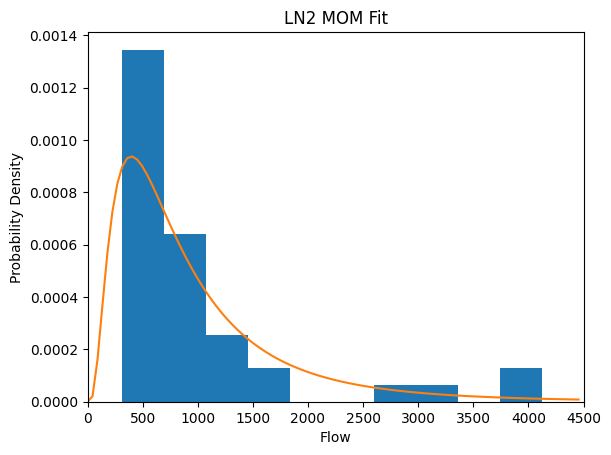

LN2 MOM mu: 6.60
LN2 MOM sigma: 0.79
LN2 MOM tau: 0.00
LN2 MOM 100-yr flood: 4600 cms




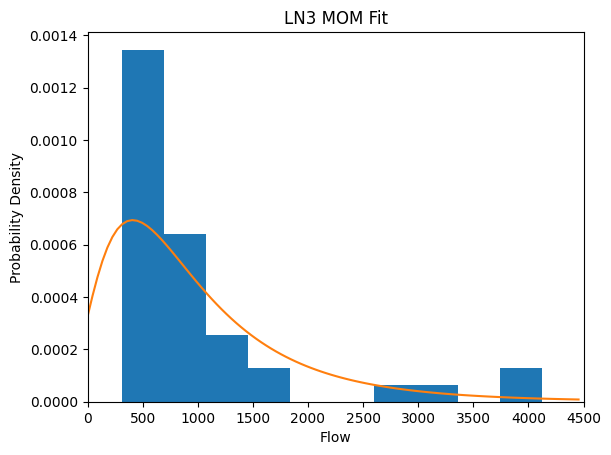

LN3 MOM mu: 7.03
LN3 MOM sigma: 0.62
LN3 MOM tau: -357.72
LN3 MOM 100-yr flood: 4390 cms




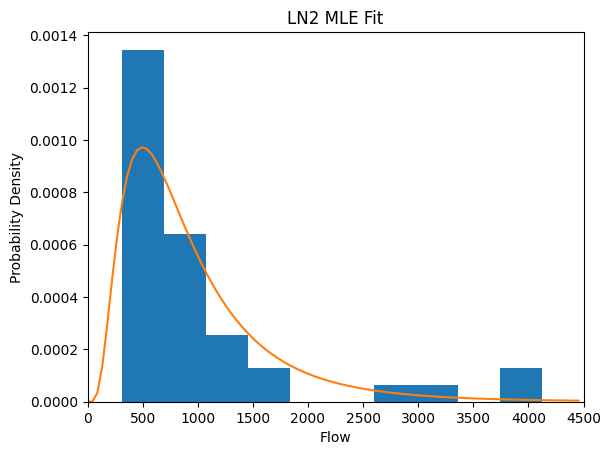

LN2 MLE mu: 6.65
LN2 MLE sigma: 0.66
LN2 MLE tau: 0.00
LN2 MLE 100-yr flood: 3600 cms




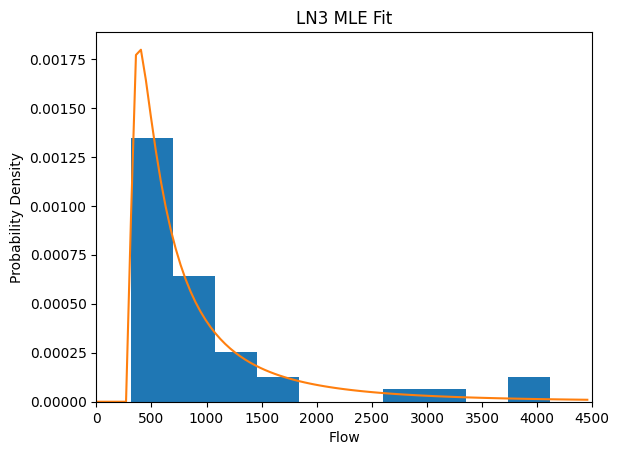

LN3 MLE mu: 5.92
LN3 MLE sigma: 1.18
LN3 MLE tau: 291.25
LN3 MLE 100-yr flood: 6087 cms




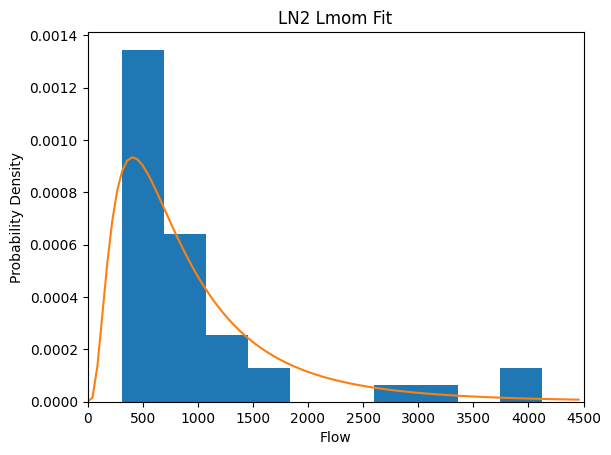

LN2 Lmom mu: 6.61
LN2 Lmom sigma: 0.77
LN2 Lmom tau: 0.00
LN2 Lmom 100-yr flood: 4506 cms




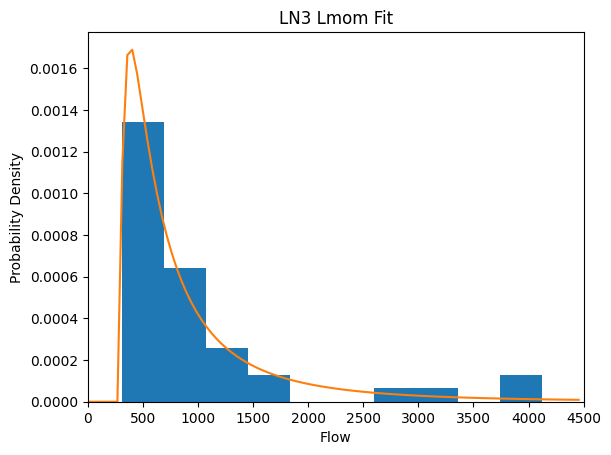

LN3 Lmom mu: 5.97
LN3 Lmom sigma: 1.12
LN3 Lmom tau: 273.69
LN3 Lmom 100-yr flood: 5555 cms




In [12]:
methods = ["MOM", "MLE", "Lmom"]
npars = [2, 3]

for method in methods:
  for npar in npars:
    distfit = LogNormal()
    distfit.fit(maxQ["Flow"],method, npar)
    q100 = distfit.findReturnPd(100)
    distfit.plotHistPDF(maxQ["Flow"], 0, 4500, "LN" + str(npar) + " " + str(method) + " Fit")
    print("LN%d %s mu: %0.2f" % (npar, method, distfit.mu))
    print("LN%d %s sigma: %0.2f" % (npar, method, distfit.sigma))
    print("LN%d %s tau: %0.2f" % (npar, method, distfit.tau))
    print("LN%d %s 100-yr flood: %0.0f cms" % (npar, method, q100))
    print("\n")